In [ ]:
!pip3 install librosa

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [2]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [3]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

./vox_dev_wav/wav/id10016/hgB5ziAudzU/
./vox_dev_wav/wav/id10016/Zxab80IZxU8/
./vox_dev_wav/wav/id10016/SCFgvk0Sm24/
./vox_dev_wav/wav/id10016/k4l2cRqjT78/
./vox_dev_wav/wav/id10016/7OacMAs-Crc/
./vox_dev_wav/wav/id10016/j0CaA8LPTdc/
./vox_dev_wav/wav/id10016/CsU9a10ccxA/
./vox_dev_wav/wav/id10016/WfkA4lUZwZ4/
./vox_dev_wav/wav/id10016/LSeSZiv7evE/
./vox_dev_wav/wav/id10016/5xGJYiNH2Jw/
./vox_dev_wav/wav/id10016/dOnuu_9-nyI/
./vox_dev_wav/wav/id10016/pdTdefdQ_QI/
./vox_dev_wav/wav/id10016/7FOcBtZM-rI/
./vox_dev_wav/wav/id10016/WwguhI5dInQ/
./vox_dev_wav/wav/id10016/l5sY-WWVnZM/
./vox_dev_wav/wav/id10016/37mbJ9bXK28/
./vox_dev_wav/wav/id10016/8gWjr_-ROCc/
./vox_dev_wav/wav/id10016/uM5GCGOXVXc/
./vox_dev_wav/wav/id10016/FDXUYIgkTgk/
./vox_dev_wav/wav/id10016/vpnw2jQlZn4/
./vox_dev_wav/wav/id10016/bIi7FnNx6m0/
./vox_dev_wav/wav/id10016/wg6IOBMAdOc/
./vox_dev_wav/wav/id10016/ywRolvE7ToY/
./vox_dev_wav/wav/id10016/NJygdnZs634/
./vox_dev_wav/wav/id10016/fb31EtxsZDs/
./vox_dev_wav/wav/id10016

In [21]:
df = pd.DataFrame(raw)
df = df[:200]
print(df.shape)
df.head()

(200, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 80% train and 20% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [22]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (140, 2), Test set size (60, 2)


True

In [23]:
n_mfcc = 20
def extract_mfcc(row, nr_mfcc):
    signal ,sr = librosa.load(row)
    mfcc_feature = librosa.feature.mfcc(signal, n_mfcc=nr_mfcc, sr=sr, hop_length=256)
    delta_feature = librosa.feature.delta(mfcc_feature)
    
    mfcc_feature = np.mean(mfcc_feature.T,axis=0)
    delta_feature = np.mean(delta_feature.T, axis=0)

    return pd.Series([mfcc_feature, delta_feature])

In [24]:
df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [25]:
df_train.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [26]:
df_test.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [27]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta columns
X = df_train.iloc[:,2:4]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(),X_val['delta'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')


Number of speakers is 3
Train set size: (98, 40), Validation set size (42, 40)


## Deep Learning Model

In [28]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               4100      
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

In [29]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 50
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
13/13 [==============================] - 1s 35ms/step - loss: 38.2401 - accuracy: 0.3469 - val_loss: 8.1072 - val_accuracy: 0.4048

Epoch 00001: val_loss improved from inf to 8.10721, saving model to saved_models/speakers_classification.hdf5
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 32.2724 - accuracy: 0.3776 - val_loss: 2.9926 - val_accuracy: 0.2619

Epoch 00002: val_loss improved from 8.10721 to 2.99264, saving model to saved_models/speakers_classification.hdf5
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 28.3043 - accuracy: 0.3265 - val_loss: 4.6217 - val_accuracy: 0.2619

Epoch 00003: val_loss did not improve from 2.99264
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 17.4164 - accuracy: 0.3673 - val_loss: 6.4313 - val_accuracy: 0.2619

Epoch 00004: val_loss did not improve from 2.99264
Epoch 5/50
13/13 [==============================] - 0s 9ms/step - loss: 18.8311 - accuracy: 0.3673 - va

### Check training history

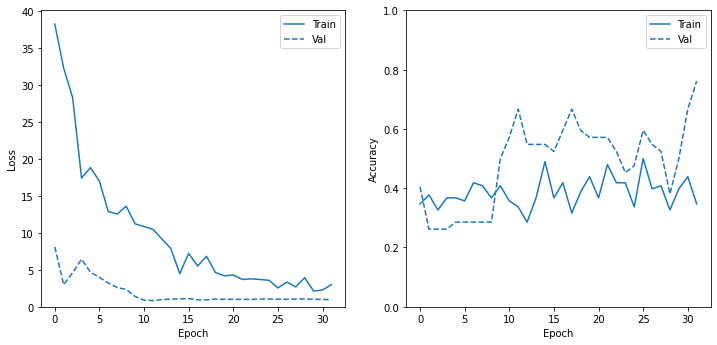

In [30]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [32]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),df_test['delta'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(60, 40)
['id10009' 'id10007' 'id10006' 'id10007' 'id10007' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10009' 'id10007' 'id10009' 'id10007'
 'id10007' 'id10006' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10006' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10006' 'id10007' 'id10006' 'id10007'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10009' 'id10006'
 'id10007' 'id10006' 'id10006' 'id10006' 'id10009' 'id10006' 'id10006'
 'id10009' 'id10006' 'id10009' 'id10006']
              precision    recall  f1-score   support

     id10006       0.72      0.72      0.72        18
     id10007       0.70      0.88      0.78        24
     id10009       0.67      0.44      0.53        18

    accuracy                           0.70        60
   macro avg       0.70      0.68      0.68        60
weighted avg       0.70      0.70      0.69        60



In [20]:
# clip = '/Users/vpapadop/Documents/GitHub/speaker-similarity/vox_dev_wav/wav/id10001/1zcIwhmdeo4/00001.wav'
# tmp = pd.DataFrame()
# tmp[['mfcc', 'delta']] = extract_mfcc(clip,20)
# X_tmp = np.hstack((tmp['mfcc'].to_list(),tmp['delta'].to_list()))
# X_tmp = np.expand_dims(X_tmp, axis=0)
# print(X_tmp.shape)

# y_pred = model.predict(X_tmp)
# print(y_pred)

(1, 40)
[[1.]]


## Gausian Mixture Model